In [1]:
# !pip install numba & conda install cudatoolkit

In [1]:
################# import libs #############

from utils import *
#from numba import jit, cuda


In [2]:
# see data path
print('LOB Path: ',NqPath)

LOB Path:  C:/Users/kasra/Downloads/Ten-Surf/Tensurf-RL/tensurfrl/data/LOB1, NQ, 1_1min.csv


In [3]:
preProcessedData = lobPreprocessing(NqPath)
data = preProcessedData.final()

ParserError: Unknown string format: time,open,high,low,close,Volume,NumTrades,Bid_Volume,Ask_Volume,bid_number,ask_number,AskBidDiffHigh,AskBidDiffLow,AskBidNumTradesDiffHigh,AskBidNumTradesDiffLow,UpDownVolDiffHigh,UpDownVolDiffLow,sum_lob_bid,sum_lob_ask

In [ ]:
data

array([  2.33164441,   2.33254355,   2.33344269,   2.33434182,
         2.33524096,   2.3361401 ,   2.33703924,   2.33793838,
         2.33883751,   2.33973665,   2.34063579,   2.34153493,
         2.34243407,   2.34333321,   2.34423234,   2.34513148,
         2.34603062,   2.34692976,   2.3478289 ,   2.34872803,
        -1.00560707,   0.05561781,   1.64745513,   1.64745513,
         1.64745513,   4.30051733,  -1.00560707,   3.76990489,
        -1.00560707,   2.17806757,   2.17806757,   1.64745513,
         2.70868001,   1.11684269,  -0.47499463,   0.05561781,
         3.76990489,   3.76990489,  -1.00560707,  -0.47499463,
       -30.17017283, -28.06741282, -25.87182462, -23.18384348,
       -10.7973358 ,   1.31068734,   1.71428811,   1.76675621,
         2.77172213,   5.33862304,   5.34669505,   6.33551694,
         7.10235841,   7.87222688,   8.08714429,   8.57550122,
         8.67640142,   9.35041471,   9.38270277,   9.38371177,
        -1.0383043 ,  -1.0383043 ,  -1.0383043 ,  -1.03

In [3]:
######################### Train Section ############################
####################################################################


################ data preprocessing  for forex STOCK ###########

preProcessedData = lobPreprocessing(NqPath)
trainData, testData, dataTrain, dataTest = preProcessedData.final()


################## initialize models,memory and etc ##################
       
Actor_model = Actor(np.shape(trainData)[1], np.shape(outPutOfQ)[0])
Actor_model_main= Actor_model.model

Critic_model= Critic(np.shape(trainData)[1])
Critic_model_main= Critic_model.model

env = dict()
memory = deque(maxlen = relayMemorySize)
selectedAction = actions[random.randint(0, len(actions)-1)]

# td_target_batch = []
# advatnage_batch = []

############################### gpu supporting########################
#!@jit(target ="cuda")

########################## Train loop #########################

for i in range(len(trainData)-1):

    ############################ current state #############
    state = trainData[i, :]
    
    ########################### transition between state and action #####################
    env_ = openOrClosePosition(env, selectedAction, i, dataTrain, margin,  Sl, Tp)   
    env = env_.tradeCheck() 

    ################################## next observation #################                  
    nextState = trainData[i+1, :] 
    
    ################################# reward calculation ######
    rewardCalculating = rewardCalculation(env, i, selectedAction, dataTrain, stepSwith = True)
    reward = rewardCalculating.reward()
    
        
    def td_targets(reward, next_state):

        v_value = Critic_model_main.predict(
        np.reshape(nextState,(1, np.shape(nextState)[0])),verbose=0)
        
        return (reward + (gamma * v_value))

    def advatnages(td_target, baselines):
    
        return (td_target - baselines)


    td_target = td_targets((reward) , nextState)
    
    advantage = advatnages(td_target, Critic_model_main.predict(np.reshape(state,(1, np.shape(state)[0])),verbose=0))
   
    # td_target_batch.append(td_target)
    # advatnage_batch.append(advantage)
    ################################### saving to memory ###################
    memory.append([state, actionConverting[actions.index(selectedAction)], reward, nextState,td_target,advantage])  

    ########################## action selection ########################
    
    if len(memory) % batchSize==0:
        
        # trainer = updatinQtable(memory, batchSize, Q, gamma, nextState)
        # Q = trainer.updating()
        print("A2C updated")
        
        # if epsilon > epsilonFinal:
        #    epsilon *= epsilonDecay

        Actor_model_main = Actor_model.train(memory,Actor_model_main)
        
        Critic_model_main = Critic_model.train(memory,Critic_model_main)

        memory = deque(maxlen = relayMemorySize)
        # td_target_batch = []
        # advatnage_batch = []
    
    #####################  select action according to decided policy #####################

    policy_ = policy(Actor_model_main, actions, state, epsilon)

    selectedAction = policy_.actionSelection()
    
    
    ############################# state updating ##########################
    state = nextState

    ############################## save models ##########################

#Q.save("DQN.csv")
    


c:\Users\kasra\.conda\envs\Ai\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
c:\Users\kasra\.conda\envs\Ai\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


TypeError: object of type 'NoneType' has no len()

In [5]:
############################# test section #########################
####################################################################

################## initialize models,memory and etc ##################

envTest = dict()
memoryTest = deque(maxlen = relayMemorySize)
selectedAction = actions[random.randint(0,len(actions)-1)]


######################### test loop ########################
for i in range(len(testData)-1):
    
    ############################ current state #############
    test_state = testData[i, :]

    ########################### transition between state and action #####################
    env_ = openOrClosePosition(envTest, selectedAction, i, dataTest, margin,  Sl, Tp)   
    envTest = env_.tradeCheck() 

    ########################## next observation ######################                  
    test_nextState = testData[i+1, :] 
    
    ######################### reward calculation ######################
    rewardCalculating = rewardCalculation(envTest, i, selectedAction, dataTest, stepSwith = True)
    reward = rewardCalculating.reward()
    
    ################################### saving to memory ###################
    memoryTest.append([test_state, actionConverting[actions.index(selectedAction)], reward, test_nextState])       
    
    ######################                   ####################
    
    # if len(memoryTest) >= numberOfFirstBatchData:
        
    #     trainer = updatinQtable(memoryTest, batchSize, Q, gamma, nextState)
    #     Q = trainer.updating()
    #     print("Q test was updated")
    # if epsilonTest > epsilonFinal:
        
    #     epsilonTest *= epsilonDecay
    
    ###########################################################  select action ##################

    policy(Actor_model_main, actions, test_state, epsilon)
    
    selectedAction = policy_.actionSelection()
    
    ############################# state updating ##########################
    
    test_state = test_nextState

    ############################# test model saving #######################

# Q.save("DQNTest.csv")

In [6]:
envTest.keys()

dict_keys(['trade 1', 'trade 2'])

c:\Users\kasra\Downloads\Ten-Surf\Tensurf-RL\tensurfrl\RL-A2C\utils\showTraderResults.py:127: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t, listOfMargin, '-ok', color="blue", linewidth = 3)


{'numberOfTrades': 2, 'numberOfBuy': 0, 'numberOfSell': 1, 'numberOfPositveSell': 0, 'numberOfPositiveBuy': 0, 'profitInBuyTrades': 0, 'profitInSellTrades': 0, 'netProfit': -4.75, 'totallProfit': 0, 'totallLoss': -4.75, 'numberOfLossBuy': 0, 'lossInBuyTrades': 0, 'numberOfLossSell': 1, 'lossInSellTrades': -4.75, 'netBuy': 0, 'netSell': 4.75, 'winRate': 0.0, 'lossRate': 50.0}


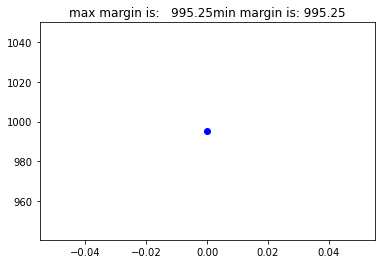

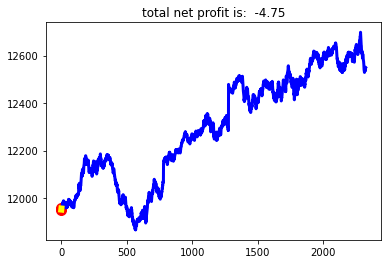

In [9]:
################## show results #############################
showTraderResults_ = showTraderResults(envTest, dataTest["Last"].values)

statements = showTraderResults_.final()

print(statements)